In [1]:
%env NICKNAME=gind.alex
%env TASK=peaks06.bed

import os
task_filename = os.environ["TASK"]

env: NICKNAME=gind.alex
env: TASK=peaks06.bed



Файл загружен с яндекс диска и скопирован на кодомо через scp

In [2]:
import pandas as pd


bed_columns = ['chrom', 'chromStart', 'chromEnd', 'strand']
df = pd.read_csv(task_filename, sep='\t', names=bed_columns)
df['width'] = df.apply(lambda row: row['chromEnd'] - row['chromStart'], axis=1)
df

,chrom,chromStart,chromEnd,strand,width
0,chr1,779670,779822,.,152
1,chr1,990867,991062,.,195
2,chr1,1000777,1001090,.,313
3,chr1,1013048,1013239,.,191
4,chr1,1044900,1045082,.,182
...,...,...,...,...,...
37469,chrX,155815377,155815527,.,150
37470,chrY,10911577,10911720,.,143
37471,chrY,11311872,11312059,.,187
37472,chrY,11326010,11326205,.,195


# Информация о файле
>Опишите скачанный файл. Как он устроен? Какую информацию можно из него получить?

Файл состоит из нескольких колонок, разделенных табом. Bed файла может содержать разное кол-во колонок с разной информацией. В данном случае это колонки:
1. название хромосомы
2. позиция начала пика в хромосоме
3. позиция конца пика в хромосоме
4. strand, то есть с какой из двух цепей ДНК было чтение. Возможные значения это `+` (), `-` и `.`. В задании во всем файле стоит точка, что означает, что информации о ориентации нету

>Посчитайте, сколько пиков было получено в данном ChIP-seq эксперименте

в этом файле 37474 пиков

# Распределение ширины пиков
Ширина пика высчитывается как разница между позицией конца и начала. Была подсчитана выше по коду

<AxesSubplot: ylabel='Frequency'>

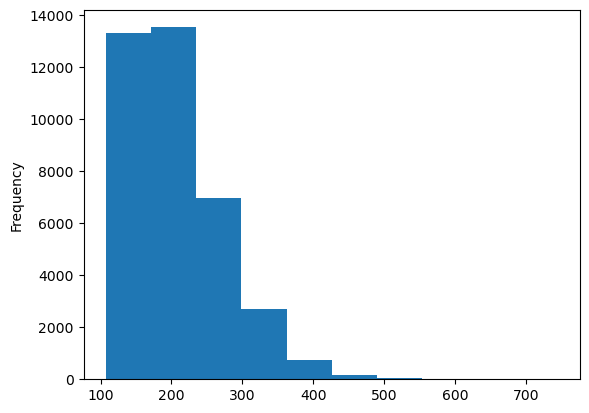

In [3]:
df['width'].plot.hist()

>Используя python, постройте график распределения ширины пиков. Прокомментируйте результат.

по графику видно, что бОльшая часть пиков сосредоточена в ширинах 100-200 нуклеотидов. Есть небольшое кол-во пиков с длиной 500 и более

# Случайная выборка широких пиков

<AxesSubplot: ylabel='Frequency'>

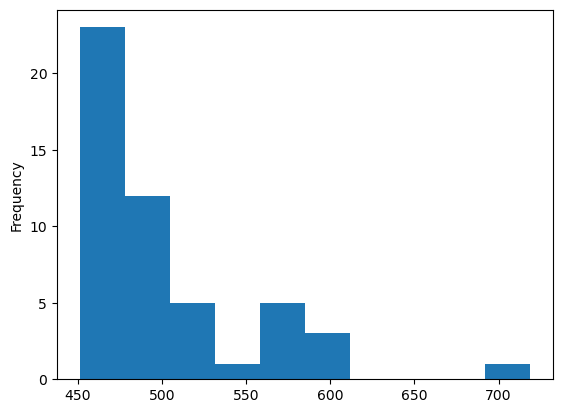

In [4]:
# second f stands for 'filtered'
top_sample = df[df.width > 450].sample(n=50, replace=False)

top_sample['width'].plot.hist()

In [5]:
top_filename = f'top.{task_filename}'
top_sample.to_csv(top_filename, header=False, index=False, sep='\t', columns=bed_columns)

In [6]:
genome_gz_filepath = f'/mnt/scratch/NGS/{os.environ["NICKNAME"]}/GRCh38.p14.genome.fa.gz'

def get_checksum(fp: str) -> str:
    checksum = !md5sum $fp
    return checksum[0].split(' ')[0]

genome_checksum = '46def657b1dda0d2aa6cdec769a196a7'
if get_checksum(genome_gz_filepath) != genome_checksum:
    !wget --timeout=900 -O $genome_gz_filepath 'https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/GRCh38.p14.genome.fa.gz'

assert get_checksum(genome_gz_filepath) == genome_checksum

In [7]:
genome_filepath = genome_gz_filepath[:-3]
!gzip --quiet --force --stdout --decompress $genome_gz_filepath  > $genome_filepath

>Воспользуйтесь возможностями bedtools getfasta и получите fasta-файл с нуклеотидными последовательностями 50 пиков, отобранных на предыдущем этапе. Убедитесь, что вы использовали верный референсный геном

In [8]:
peaks_fasta_path = f'top.{task_filename}.fa'
!bedtools getfasta -fi $genome_filepath -bed $top_filename -fo $peaks_fasta_path

# MEME-ChIP

Запустим локальную версию. Параметры взяты из дефолтных значений с meme-suite

In [9]:
meme_dir = f'{peaks_fasta_path}.meme.d'
!/opt/meme-5.5.1/bin/meme-chip \
    -dna \
    -minw 6 \
    -maxw 15 \
    -oc $meme_dir \
    -meme-minsites 2 \
    -meme-maxsites 600 \
    -meme-nmotifs 10 \
    -streme-pvt 0.05 \
    -centrimo-score 5 \
    -centrimo-ethresh 10 \
    $peaks_fasta_path

Starting getsize: getsize top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa 1> $metrics
getsize ran successfully in 0.026374 seconds
Starting fasta-most: fasta-most -min 50 < top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa 1> $metrics
fasta-most ran successfully in 0.061926 seconds
Starting fasta-center: fasta-center -dna -len 100 < top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa 1> top.peaks06.bed.fa.meme.d/seqs-centered
fasta-center ran successfully in 0.058431 seconds
Starting fasta-get-markov: fasta-get-markov -nostatus -nosummary -dna -m 2 top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa top.peaks06.bed.fa.meme.d/background
fasta-get-markov ran successfully in 0.032175 seconds
Starting meme: meme top.peaks06.bed.fa.meme.d/seqs-centered -oc top.peaks06.bed.fa.meme.d/meme_out -mod zoops -nmotifs 10 -minw 6 -maxw 15 -bfile top.peaks06.bed.fa.meme.d/background -dna -minsites 2 -maxsites 600 -revcomp -nostatus
Maximum number of sites is exceeded. Setting to 50.
meme ran successfully in 16.524065 seco

>После того, как MEME закончит работу, просмотрите логи, которые он выдает (Status Messages). Какие программы были запущены в пайплайне?

Список запущенынз программ:
1. getsize
2. fasta-most
3. fasta-center
4. fasta-get-markov
5. meme
6. streme
7. centrimo
8. tomtom
9. spamo
10. fimo
11. meme-chip_html_to_tsv

>С какими параметрами был запущен MEME-ChIP?

Полный лог сохранен в отчете, так как это локальный запуск. Параметры приведены в нем.

### А так же

Веб версия запускает в частности tomtom для сравнения по базе данных мотивов. Локальная версия так не делает в силу того, что базы данных у нее нету. Потому скачем бд сами и запустим поиск по ней через tomtom

In [10]:
motifs_db_gz_filepath = f'/mnt/scratch/NGS/{os.environ["NICKNAME"]}/meme.motifs.db.12.25.tgz'
motifs_db_checksum = '94e4bc8097bca905ac3c14f244e9f77b'
if get_checksum(motifs_db_gz_filepath) != motifs_db_checksum:
    !wget --timeout=900 -O $motifs_db_gz_filepath 'https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz'

assert get_checksum(motifs_db_gz_filepath) == motifs_db_checksum

In [11]:
motifs_db_filepath = f'/mnt/scratch/NGS/{os.environ["NICKNAME"]}/meme.motifs.db.d'
!mkdir -p $motifs_db_filepath
!tar -xzf $motifs_db_gz_filepath -C $motifs_db_filepath
hocomoco_filepath = motifs_db_filepath + '/motif_databases/HOCOMOCO/H12CORE_meme_format.meme'

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'


Параметры запуска tomtom взяты дефолтными с веб версии

In [12]:
!/opt/meme-5.5.1/bin/tomtom \
    -oc $meme_dir/streme_tomtom_out.d \
    -min-overlap 5 \
    -dist pearson \
    -evalue \
    -thresh 1 \
    -no-ssc \
    $meme_dir/streme_out/streme.xml \
    $hocomoco_filepath

Writing results to output directory 'top.peaks06.bed.fa.meme.d/streme_tomtom_out.d'.
Processing query 1 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993533
#   Estimated pi_0=0.993533
Processing query 2 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00088
#   Estimated pi_0=1
Processing query 3 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.999398
#   Estimated pi_0=1
Processing query 4 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00189
#   Estimated pi_0=1


>Откройте и изучите HTML-отчет - MEME-ChIP HTML output. Опишите результаты. Сколько мотивов было найдено, с какими значениями E-value

Нашелся один мотив, прошедший по E-value со значением = 2.0e-048. Посмотрим на его лого

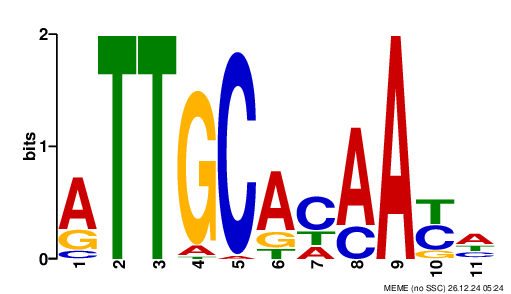

In [15]:
from IPython import display


display.display(display.Image(filename=f'{meme_dir}/meme_out/logo1.png'))

>Найденные похожие мотивы будут объединены в один кластер. Чтобы увидеть, какие еще мотивы были найдены, перейдите по ссылке на отчет MEME в столбце Discovery/Enrichment Program. Опишите найденные мотивы, определите в скольких последовательностях они встретились.

Для ответа на эти вопросы не будем смотреть на лого. Посмотрим в текстовых выхлоп meme

In [16]:
!grep -E 'MOTIF.*MEME-.*width.*sites.*llr.*E-value' $meme_dir/meme_out/meme.txt

MOTIF ATTGCACAAYH MEME-1	width =  11  sites =  47  llr = 425  E-value = 2.0e-048
MOTIF GCSRDGCCGCVSGCG MEME-2	width =  15  sites =   9  llr = 124  E-value = 4.1e-001
MOTIF GCTCAYTCATG MEME-3	width =  11  sites =   8  llr = 93  E-value = 3.1e+003
MOTIF GCCAGVGGCBG MEME-4	width =  11  sites =   9  llr = 100  E-value = 1.2e+004
MOTIF GAGGMKGGGARNGCG MEME-5	width =  15  sites =   7  llr = 97  E-value = 1.2e+004
MOTIF CCTCACCMAGT MEME-6	width =  11  sites =   5  llr = 64  E-value = 1.2e+005
MOTIF GCCTGGRS MEME-7	width =   8  sites =   6  llr = 61  E-value = 4.1e+005
MOTIF CTGCTGGC MEME-8	width =   8  sites =   2  llr = 23  E-value = 2.7e+005
MOTIF GCACMGGGC MEME-9	width =   9  sites =   2  llr = 25  E-value = 3.1e+005
MOTIF CCTSGGGGC MEME-10	width =   9  sites =   2  llr = 25  E-value = 1.9e+005


В этих строках выхлопа описаны мотивы, их ширина, e-value и в скольких сайтах они были найдены

>Изучите и опишите результаты сравнения найденного мотива с мотивами из БД (столбец Known or Similar Motifs).

Так как этот столбец локальной версией не генерируется, то придется посмотреть на отдельно сгенерированный tomtom.tsv, который содержит информацию, которая в веб версии используется источником для столбеца Known or Similar Motifs

In [13]:
tomtom = pd.read_csv(f'{meme_dir}/streme_tomtom_out.d/tomtom.tsv', sep='\t', comment='#')
tomtom.sort_values(by=['p-value'])
tomtom

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,1-ATTGCACAAYH,CEBPB.H12CORE.0.P.B,0,3.189240e-08,0.000046,0.000091,11,ATTGCACAATA,ATTGCGCAACC,-
1,1-ATTGCACAAYH,CEBPA.H12CORE.0.P.B,1,1.009340e-07,0.000146,0.000145,11,ATTGCACAATA,TATTGCGCAACC,-
2,1-ATTGCACAAYH,CEBPE.H12CORE.0.P.B,0,1.818350e-07,0.000262,0.000160,11,ATTGCACAATA,ATTGCACAACC,-
3,1-ATTGCACAAYH,CEBPG.H12CORE.0.P.B,1,2.649760e-07,0.000382,0.000160,11,ATTGCACAATA,TATTGCGTAATA,+
4,1-ATTGCACAAYH,CEBPD.H12CORE.0.P.B,1,2.791100e-07,0.000403,0.000160,10,ATTGCACAATA,GATTGCACAAT,+
5,1-ATTGCACAAYH,CEBPG.H12CORE.1.SM.B,1,4.267750e-06,0.006158,0.002040,11,ATTGCACAATA,TATTGCGTAATA,+
6,1-ATTGCACAAYH,CEBPB.H12CORE.1.SM.B,1,4.982960e-05,0.071904,0.014852,11,ATTGCACAATA,CATTGCGCAACCC,+
7,1-ATTGCACAAYH,CEBPD.H12CORE.1.SM.B,2,4.982960e-05,0.071904,0.014852,11,ATTGCACAATA,GTATTGCGTAATT,+
8,1-ATTGCACAAYH,NFIL3.H12CORE.0.P.B,0,5.179770e-05,0.074744,0.014852,10,ATTGCACAATA,GTTACATAAC,-
9,1-ATTGCACAAYH,CEBPE.H12CORE.1.SM.B,1,9.415880e-05,0.135871,0.020768,11,ATTGCACAATA,CGTTGCGCAATCC,+


Возьмем по всем найденным ТФ информацию из юнипрота

In [14]:
import json
from IPython import display


best_match = tomtom['Target_ID'][0]
hocomoco_link = f'https://hocomoco12.autosome.org/motif/{best_match}#maininfo'
uniprot_accessions = !curl -s $hocomoco_link -o - | grep 'UniProt AC' | grep -oP '\?uniprot=[a-zA-Z0-9]+' | cut -d '=' -f 2

uniprot_infos = []
for acc in uniprot_accessions:
    body = !curl -s -H "Accept: application/json" "https://rest.uniprot.org/uniprotkb/$acc"
    res = json.loads(body[0])
    info = {
        'acc': acc,
        'id': res.get('uniProtkbId'),
        'pdb': [],
        'supfam': [],
        'supfam_names': set(),
    }
    for desc in res.get('uniProtKBCrossReferences', []):
        if 'database' in desc and desc['database'] == 'PDB':
            info['pdb'].append(desc.get('id', ''))
        elif 'database' in desc and desc['database'] == 'SUPFAM':
            supfam = {'id': desc.get('id', '')}
            for prop in desc.get('properties', []):
                if prop.get('key') == 'EntryName':
                    supfam['name'] = prop.get('value', '')
                    info['supfam_names'].add(prop.get('value', ''))
                    break
            info['supfam'].append(supfam)
    uniprot_infos.append(info)

table = """|accession|id|supfam|pdb|
|--|--|--|--|
"""
for info in uniprot_infos:
    table += f'|{info["acc"]}|{info["id"]}|{info["supfam_names"]}|{info["pdb"]}|\n'
display.display_markdown(table, raw=True)

|accession|id|supfam|pdb|
|--|--|--|--|
|P17676|CEBPB_HUMAN|{'Leucine zipper domain'}|['1GTW', '1GU4', '1GU5', '1H88', '1H89', '1H8A', '1HJB', '1IO4', '2E42', '2E43', '6MG1', '6MG2', '6MG3', '7L4V', '7UPZ', '8K8D']|
|P28033|CEBPB_MOUSE|{'Leucine zipper domain'}|['1CI6']|


>Выберите из списка похожих мотивов ТФ, который, как вы считаете, и был таргетом данного ChIP-seq эксперимента. Опишите с функциональной точки зрения выбранный ТФ.

Судя по E-value (из dataframe по файлу tomtom.tsv) я прихожу к выходу, что целью изучения был ТФ CEBPB_HUMAN c консенсусом ATTGCACAATA (в экспериментах). 
Это ажный фактор транскрипции, регулирующий экспрессию генов, участвующих в иммунных и воспалительных реакциях. 

>Какой тип ДНК-связывающего домена несет выбранный вами транскрипционный фактор? 

Все найденные ТФ по базе яв-ся доменами связи с ДНК с помощью лейциновых молний. Разные домены белка имеют хорошо разрешенную структуру 3Д (приведены в табилце выше). Источником информации о функции ТФ, указанная выше, была страница белка на юнипроте, а так же статьи в пабмеде, которые указаны в самом юнипроте - ( PubMed: 12048245 , PubMed: 1741402 , PubMed: 18647749 , PubMed: 9374525 )